# Map-based Memory Validation

The idea of a location map is to remember sensory data. For our simple navigator, sensory data is like smell: our trees distributed through the environment diffuse scents indicating their identity. At a given point, the sense of smell detects a combination of data from nearby trees.

## A simple chemical sensor

The 'scent' $z$ of a tree should be detected proprotionately to the distance from a tree. I model the decay of the scent via a diffusion process. The model for diffusion (the physical process, not the algorithm) is based on the heat equation $u(x,t)$ is $$\frac{1}{2} \frac{\partial u}{\partial t} = \sum_i \frac{\partial^2 u}{\partial x_i^2} = \Delta u,$$ where $\Delta u$ is called the _Laplacian_. The heat equation is solved by
$$u(x, t) = \frac{c}{\sqrt{t^d}} \exp\left(-\frac{1}{2t} \|x - \mu\|^2\right),$$ 
where $d$ is the dimension of the space, $c$ is any constant, and $\mu$ is the intial point where diffusion starts.

Here $u(x,t)$ is the diffused quantity. For clarity, $x$ is the location of the sensor, and $\mu$ is the location of the source tree. At $u(x, 0) = c$, this is a point mass at $\mu$. Our interest is to choose a virtual time $t$ such that controls the spread of the tree's sense such that (a) trees can be sensed from a distance, and (b) trees are still distinct [note that $u(x, \infty) = 0$]. For simplicity, we set $c = \sqrt{t^d}$ so that $u(\mu, t) = 1$ for all $t$; that is, the sensor outputs the vector with all ones at the source. 

To choose $t$, we set a maximum distance $M$ and a target sensory value $a$ such that the diffused scent has magnitude $a$ at distance $M$. That is, $u(x, t_M) = a$ when $\|x - \mu\| = M$, which reduces to $$u(x, t) = \exp\left(-\frac{M^2}{2t}\right) = a \quad\quad\implies\quad\quad t_M = \frac{M^2}{2 \log({1}/{a})}.$$

Finally, given a set of trees at locations $\{\ell_i\}$ with scent embeddings $z_i$, a sensor at position $x$ will read the sum of the diffused scents
$$
z = \sum_i z_i \exp\left(-\frac{1}{2t_M} \| x - \ell_i\|^2\right) = KZ
$$
for the kernel matrix $K_ij = u_{i}(x_j, t_M)$ and scent matrix $Z$ with $z_i$ as the $i^{th}$ row.

This sensor is implemented by the following function, with some wrapping to handle batch sizes and the possibility of multiple sensors.

In [1]:
import torch
import math

def sense(self, source_locations: torch.Tensor, source_embeddings: torch.Tensor, sensor_positions: torch.Tensor, 
          M: float, a: float=0.1) -> torch.Tensor:
    # we expect source_locations to be a >2D tensor of shape (..., num_sources, dim)
    # we expect sensor_positions to be a >2D tensor of shape (..., num_sensors, dim) OR a 1D tensor of shape (..., dim)
    # we expect source_embeddings to be a >2D tensor of shape (..., num_sources, embed_dim)

    # special case for a single sensor
    single_sensor = sensor_positions.ndim < source_locations.ndim
    if single_sensor:
        sensor_positions = sensor_positions[..., None, :]
    
    assert source_locations.ndim == sensor_positions.ndim == source_embeddings.ndim
   
    # compute the virtual time
    t_M = M**2 / 2 / math.log(1/a)

    # compute the distance between the sensor and the source trees
    # This will yield a tensor of shape (..., num_sensors, num_sources)
    distances = torch.cdist(sensor_positions, source_locations)

    # now compute the kernel for each sensor-source pair as shape (..., num_sensors, num_sources)
    kernel = torch.exp(-0.5 * (distances).pow(2) / t_M)

    # now compute the embedding for each sensor as shape (..., num_sensors, embed_dim)
    if kernel.ndim == 2:
        embedding = torch.mm(kernel, source_embeddings)
    else:
        embedding = torch.bmm(kernel, source_embeddings)

    if single_sensor:
        embedding = embedding.squeeze(-2)

    return embedding

## A Memory to Remember Senses by Location

The purpose of the memory is to remember what would be sensed in a given location that was visited. In a continuous setting, we will never visit the exact same location twice, so we do not want a memory _per se_. Instead, we want an interpolator that can predict the expected sensory value well.

Suppose, then that our agent has visited a sequence of locations $\ell_t$, observing $z_t$ at each step, yielding a sequence of pairs $\{(\ell_t, z_t)\}$. Given a new location $\ell$, we want to estimate $\hat{z} = f(\ell)$ provided that for all $t$, $z_t \approx f(\ell_t)$. But _this is just a regression_! Our "memory" is not really a memory; it is a regression model trained from the dataset of visited points.

Our memory, then is a regression function $f$ trained on the visited points. However, we need a model that can be rapidly trained, because the memory needs to be immediately available from timestep to timestep. As a first approach, we can simply interpolate with an attention kernel.

In our case, our location estimates $\ell_t$ are generated by the agent and come with error, which we model as a Gaussian with diagonal covariance matrix (_i.e._, independent variation in each location dimension). Thus to each $\ell_t \in \mathbb{R}^d$ we associate a vector of deviations $\sigma_t \in \mathbb{R}^d$, and we want to regress $\hat{z} = f(\ell, \sigma)$. We can compute a location affinity kernel $k(\ell, \ell_t)$ between the inputs $\ell$ and $\sigma$ based on the $\sigma$-scaled distance as 
$$
\log k(\ell, \ell_t) = \quad-\frac{1}{2}\left\|\frac{\ell - \ell_t}{\sqrt{\sigma^2 + \sigma_t^2}}\right\|^2 
\quad-\sum_i \log | \sigma_i^2 + \sigma_{t,i}^2 | 
\quad-\frac{d}{2}\log 2\pi
$$
where logs make the relationships easier to see. Vector division is componentwise, and $k(\ell, \ell_t)$ is just the density function of a Gaussian $\mathcal{N}\left(\ell_t, \textrm{diag}\left(\sigma^2 + \sigma_t^2\right)\right)$ -- the variance combines the measurement error on both $\ell$ and $\ell_t$ and represents the variance of $\ell + \ell_t$.

Next, we can take a softmax over $\log k$ to get a set of affinity weights $w_t$ that will weight our dataset examples according to their closeness to the query point $\ell$, accounting for measurement error:
$$
w_t = \textrm{softmax} \left(\log k(\ell, \ell_t)\right) = \frac{k(\ell, \ell_t)}{\sum_s k(\ell, \ell_s)}
$$

From here, we can regress directly on the dataset to obtain the sensor estimate $\hat{z}$ by
$$
\hat{z} = \sum_t w_t z_t,
$$
which estimates the sensor output as a weighted average of the past sensor values.

In [2]:
import math

def read_memory(self, query_location: torch.Tensor, query_deviation: torch.Tensor, 
                memory_locations: torch.Tensor, memory_deviation: torch.Tensor, 
                memory_values: torch.Tensor) -> torch.Tensor:
    # we expect query_location to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect query_deviation to be a tensor of shape (..., num_queries, dim) (but num_queries can be 1 or missing)
    # we expect memory_locations to be a tensor of shape (..., num_keys, dim)
    # we expect memory_deviation to be a tensor of shape (..., num_keys, dim)
    # we expect memory_values to be a tensor of shape (..., num_keys, embed_dim)

    single_query = query_location.ndim < memory_locations.ndim
    if single_query:
        query_locations = query_location[..., None, :]
        query_deviations = query_deviation[..., None, :]
    
    assert query_locations.ndim == query_deviations.ndim == memory_locations.ndim == memory_deviation.ndim == memory_values.ndim

    # compute the combined variance, which has shape (..., num_queries, num_keys)
    variance = query_deviation**2 + memory_deviation**2
    log_k = (
        - 0.5 * ((query_location - memory_locations).pow(2) / variance).sum(dim=-1) 
        - torch.log(variance).sum(dim=-1)
        - 0.5 * math.log(2 * math.pi) * variance.shape[-1]
    )

    # the location affinity weights have shape (..., num_queries, num_keys)
    w = torch.softmax(log_k, dim=-1)

    hat_z = torch.bmm(w, memory_values)

    if single_query:
        hat_z = hat_z.squeeze(-2)

    return hat_z

Now, you might notice that this kernel looks very similar to dot product attention, and then you might ask whether we could recast it to make use of efficient tools for handling long-context attention, such as flash attention. The answer is that _you could_, but you would be changing the topology of the location space in so doing, and you would have to work that change all the way through the math. We might do that later. For now, the clarity of keeping our space as $\mathbb{R}^d$ is preferable.

## Testing Basic Memory Reads

We will now check how well a memory that is populated with sensor data can do at building a model of a tree world. For this purpose, we'll allow our locations to be the "true" positions of our 2-D world space and avoid worrying about the agent learning a location representation for now; if the memory won't work for the the "truth", then it won't work for latent approximations of locations either. Also, we'll keep it simple by avoiding any compression of the sensor data; we'll just work with the sensor data in full dimension (which comes from a sentence embedding model here, specifically BAAI/bge-large-en-v1.5)

First we import the relevant elements of our simulation, and initialize a tree world.

In [3]:
from tree_world.simulation import TreeWorld, TreeWorldConfig, SimpleSensor

# create a world and memory
print("Creating world and memory...")
config = TreeWorldConfig()
world = TreeWorld.random_from_config(config)
config.embed_dim = 1024  # we'll use embeddings from text, and 

# print out the tree locations
print("--------------------------------")
for tree in world.trees:
    print(tree.tree_id, tree.name, tree.location.detach().cpu().numpy().tolist())
print("--------------------------------")

print("Creating sensor...")
sensor = SimpleSensor.from_config(config)

closest_distance, sense_value, closest_tree = sensor.sense(world, torch.zeros(2), None)

print("--------------------------------")
print(f"Testing sensor at (0, 0)")
print(f"Closest tree: {closest_tree.tree_id} ({closest_tree.name}) at {closest_distance.item():.2f}m")
print(f"Sense value: {sense_value}")
print(f"Tree embeddings: {closest_tree.embedding}")
print("--------------------------------")


Creating world and memory...
--------------------------------
Uma desert rose [-20.840225219726562, -177.07272338867188]
Homer banana [240.46690368652344, 134.44651794433594]
Ada strychnine fruit [184.09408569335938, -118.60916900634766]
Jimmy cherry [113.5208511352539, 262.5126037597656]
Nate desert rose [153.82957458496094, -266.45941162109375]
Ziggy date [-173.5131072998047, 103.40473937988281]
Bob plum [57.85466384887695, 100.15052795410156]
Eleanor desert rose [-164.73800659179688, -49.80597686767578]
Eve elderberry [331.75848388671875, 190.01715087890625]
Bertha pear [-0.38885214924812317, -155.81642150878906]
Olivia date [-381.37677001953125, 33.30934524536133]
Monica mango [-1.4480600357055664, -4.474984645843506]
Ian manchineel [-299.394287109375, 96.22804260253906]
Phoebe strychnine fruit [-33.85564422607422, 371.15582275390625]
Kramer cherry [509.4917907714844, 337.633056640625]
Paul nightshade [-173.85562133789062, -301.97076416015625]
Theresa strychnine fruit [-103.3207168

We can see that each tree has a name, a fruit type, and a 2-D coordinate in the world. The tree embeddings is generated under the hood by passing the name and tree type to our sentence embedder (see `tree_world.embeddings.embed_text_sentence_transformers` for the code).

Further, we have built a sensor and we can see that the embedding of the closest tree to the origin is similar to the value that we read from the sensor at the origin.

Let's find a way to see what the sensors can "see"

In [4]:
print("Preparing to make a grid of points...")

def make_2D_grid(points_per_axis: int, world_size: float=500.0):
    points = torch.linspace(-world_size, world_size, points_per_axis)
    return torch.cartesian_prod(points, points)

num_points = 100
print(f"Making a grid of points, {num_points} x {num_points}...")

grid = make_2D_grid(points_per_axis=num_points)

print(f"Made a grid of points: {grid.shape}; running sensor...")

_, sensor_values, _ = sensor.sense(world, grid, None)

print(f"sensor_values.shape: {sensor_values.shape}")

Preparing to make a grid of points...
Making a grid of points, 100 x 100...
Made a grid of points: torch.Size([10000, 2]); running sensor...
sensor_values.shape: torch.Size([10000, 1024])


In [5]:
%matplotlib inline

In [6]:
# generate a 3D embedding of the sensor values
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


def make_rgb_model_from_sensor_values(values: torch.Tensor):

    sensor_np = values.cpu().numpy()

    N = sensor_np.shape[0]
    k = min(4000, N)                    # tune subset size
    idx = np.random.RandomState(42).choice(N, size=k, replace=False)    

    pca = PCA(n_components=3)
    rgb = pca.fit_transform(sensor_np[idx])
    return lambda x: pca.transform(x), rgb.min(axis=0), rgb.max(axis=0)


In [7]:
rgb_model, rgb_min, rgb_max = make_rgb_model_from_sensor_values(sensor_values)

In [ ]:
def plot_sensor_field(values: torch.Tensor, key="Sensor Field"):
    rgb = rgb_model(values.cpu().numpy())

    # normalize the colors to be between 0 and 1 for display
    rgb = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-8)
    rgb = np.clip(rgb, 0, 1)

    H = W = int(math.sqrt(values.shape[0]))
    img = rgb.reshape(H, W, 3)

    fig, ax = plt.subplots(figsize=(6,6))
    ax.imshow(
        img,
        extent=[-500, 500, -500, 500],  # [xmin, xmax, ymin, ymax]
        origin='lower',
        interpolation='nearest',
        aspect='equal',  # square pixels in world space
    )
    ax.set_title(f"{key} (PCA colors)")
    ax.axis("off")

    for tree in world.trees:
        x, y = tree.location.cpu().numpy()
        color = "red" if tree.is_poisonous else "green"
        ax.scatter(
            y, x,
            c=color, marker="x" if tree.is_poisonous else "o",
            s=80, edgecolor="k"
        )

    return img, fig

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_30684/2285017118.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


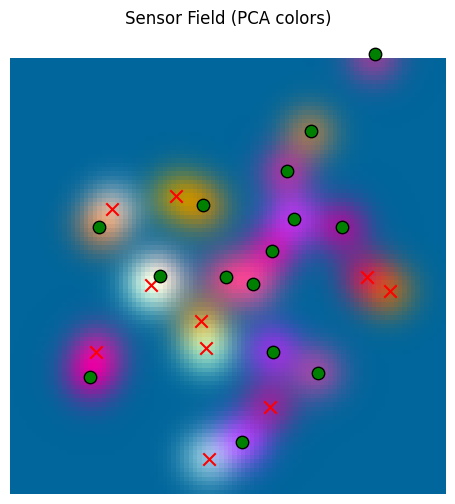

In [ ]:
base_sensor_field, fig = plot_sensor_field(sensor_values)

Now, let's create a memory and provide a way to show its contents.

In [23]:

from tree_world.models.memory import BidirectionalMemory

memory = BidirectionalMemory(
    location_dim=config.dim, 
    sensory_dim=config.sensory_embedding_dim, 
    embed_dim=config.embed_dim,   # note that if embed_dim=sensory_dim our memory does NOT compress or project inputs
    max_memory_size=1024,             # <-- beyond this size we will truncate the oldest memories
)


def plot_memory_field(train_locations: torch.Tensor, plot_locations: torch.Tensor, sd: float=1.0):
    # clear out the memory
    memory.reset()

    _, sensor_data, _ = sensor.sense(world, train_locations, None)

    # now we can call memory.write(locations, location_sds, senses) to write data
    train_location_sds = torch.empty_like(train_locations).fill_(sd)
    memory.write(train_locations, train_location_sds, sensor_data)

    # now we can call memory.read(locations, location_sds) to read data
    plot_location_sds = torch.empty_like(plot_locations).fill_(sd)
    read_data = memory.read(plot_locations[None, ...], plot_location_sds[None, ...])

    # plot the data
    plot_sensor_field(read_data.squeeze(0), key="Memory Field")

    return read_data.squeeze(0)

First, let's see how our memory does at just recalling the same data

/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_30684/2285017118.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


M - location.shape: torch.Size([1, 10000, 2])
M - location_sd.shape: torch.Size([1, 10000, 2])
M - sense.shape: torch.Size([1, 10000, 1024])


/var/folders/gw/zsqsy8v12h1fsqw6ph5ndprc0000gn/T/ipykernel_30684/2285017118.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


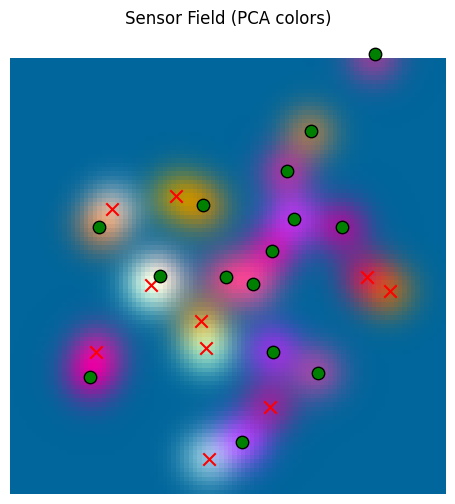

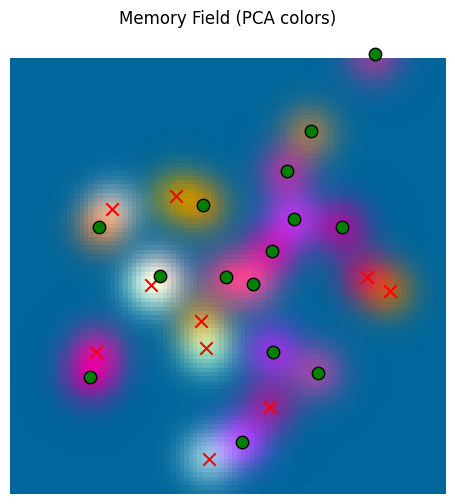

In [ ]:
train_locations = make_2D_grid(points_per_axis=100)
read_data =plot_memory_field(train_locations, train_locations)

We can see here that the memory and the sensor yield plots appear virtually the same, so the memory is reading well. Just to be sure, we can compare them directly:

In [26]:
error = torch.norm(sensor_values - read_data, dim=-1)
print(f"Min Error: {error.min().item():.6f}")
print(f"Mean Error: {error.mean().item():.6f}")
print(f"Max Error: {error.max().item():.6f}")
print(f"Std Dev on Error: {error.std().item():.6f}")


Min Error: 0.000000
Mean Error: 0.000000
Max Error: 0.000000
Std Dev on Error: 0.000000


So the memory can read and write well. Now let's give it less data. Let's start with a smaller grid.

In [27]:
train_locations = make_2D_grid(points_per_axis=10)
plot_locations = make_2D_grid(points_per_axis=10)
smaller_grid_read_data = plot_memory_field(train_locations, plot_locations)

M - location.shape: torch.Size([1, 100, 2])
M - location_sd.shape: torch.Size([1, 100, 2])
M - sense.shape: torch.Size([1, 100, 1024])


ValueError: cannot reshape array of size 300 into shape (100,100,3)